In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mesh_x_count = 30  # количество ячеек по пространству в направлении оси Ox
mesh_y_count = mesh_x_count  # количество ячеек по пространству в направлении оси Oy
mesh_t_count = 200  # количество шагов по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.18  # пористость

mu = 4  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = np.full((mesh_x_count, mesh_y_count), 30.0)  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 50  # м, ширина ячейки по оси Ox
dy = dx  # м, ширина ячейки по оси Oy

h = 50  # м, толщина пласта

b_liq = 1  # м^3/м^3, объёмный коэффициент жидкости

compr = 2.2e-9  # Па^(-1), общая сжимаемость

p_initial = 20  # МПа, начальное пластовое давление
p_initial *= 1e6  # Па, начальное пластовое давление

inj_cells = np.array([435])  # массив номеров ячеек с нагнетательными скважинами
q_inj = np.array([80])  # м^3/сут, массив расходов нагнетательных скважин в поверхностных условиях соответственно
q_inj = q_inj / (24 * 60 * 60)  # м^3/с, расходы нагнетательных скважин в поверхностных условиях

prod_cells = np.array([125, 135, 145, 425, 445, 725, 735, 745])  # массив номеров ячеек с добывающими скважинами
q_prod = np.array([40, 40, 40, 40, 40, 40, 40, 40])  # м^3/сут, массив дебитов добывающей скважины в поверхностных условиях соответственно
q_prod = q_prod / (24 * 60 * 60)  # м^3/с, дебиты добывающих скважин в поверхностных условиях

In [4]:
# отображать ли матрицы в Jupyter-тетради
display_matrices = False
# настройки отображения чисел в датафрейме
pd.options.display.float_format = '{:.2e}'.format

In [5]:
# матрица проницаемости; заполняем её значениями
# заполнение значениями выполнено в общем виде, чтобы была возможность экспериментировать с пластами произвольных размеров
# текущее ограничение: длина пласта должна быть равна его ширине
k_matrix = np.full((mesh_x_count ** 2, mesh_y_count ** 2), 0.0)
k_matrix += np.diag(k.flatten())

for i in range(mesh_x_count * mesh_y_count):
    if not (i + 1) % mesh_x_count == 0:
        k_matrix[i, i + 1] = 2 * dx / (dx / k[i // mesh_x_count, i % mesh_x_count + 1] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(1, mesh_x_count * mesh_y_count):
    if not i % mesh_x_count == 0:
        k_matrix[i, i - 1] = 2 * dx / (dx / k[i // mesh_x_count, i % mesh_x_count - 1] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(mesh_x_count * mesh_y_count - mesh_x_count):
        k_matrix[i, i + mesh_x_count] = 2 * dx / (dx / k[i // mesh_x_count + 1, i % mesh_x_count] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(mesh_x_count, mesh_x_count * mesh_y_count):
        k_matrix[i, i - mesh_x_count] = 2 * dx / (dx / k[i // mesh_x_count - 1, i % mesh_x_count] + dx / k[i // mesh_x_count, i % mesh_x_count])

if display_matrices:
    print('Матрица проницаемости:')
    df = pd.DataFrame(k_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

In [6]:
# матрица проводимости
trans_matrix = k_matrix / (mu * b_liq * dx**2)
trans_matrix -= np.diag(np.diag(trans_matrix))

if display_matrices:
    print('Матрица проводимости:')
    df = pd.DataFrame(trans_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

In [7]:
# оставшийся множитель перед производной по времени
mult_before_time_derivative = m * compr / dt

final_reservoir_matrix = trans_matrix.copy()

for i in range(mesh_x_count * mesh_y_count):
    final_reservoir_matrix[i, i] = -sum(final_reservoir_matrix[:, i]) - mult_before_time_derivative

if display_matrices:
    print('Матрица СЛАУ:')
    df = pd.DataFrame(final_reservoir_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

In [8]:
# список, в который будут добавляться поля давлений на каждом временном шаге
p = []
p.append(np.full((mesh_x_count, mesh_y_count), p_initial))

for time_step in range(mesh_t_count):
    # вектор правых частей
    d = -p[-1].flatten() * mult_before_time_derivative
    # добавление скважин
    for i, inj_cell in enumerate(inj_cells):
        d[inj_cell - 1] -= q_inj[i] / (dx * dy * h)
    for i, prod_cell in enumerate(prod_cells):
        d[prod_cell - 1] += q_prod[i] / (dx * dy * h)
    # решение СЛАУ
    solution = np.matmul(np.linalg.inv(final_reservoir_matrix), d)
    # добавление найденного поля давлений в список
    p.append(solution.reshape(mesh_x_count, mesh_y_count))

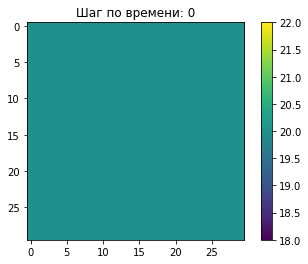

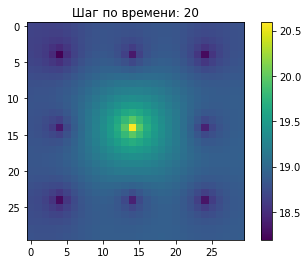

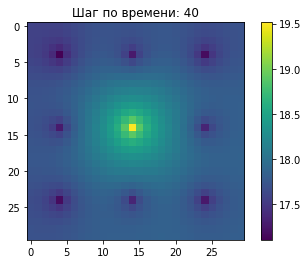

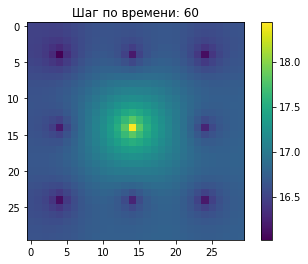

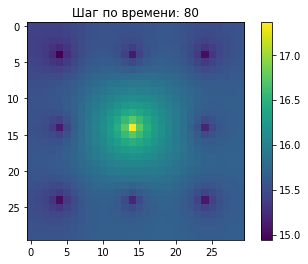

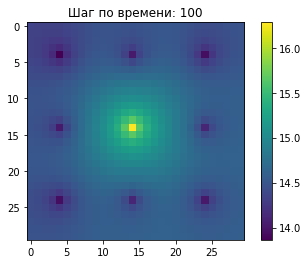

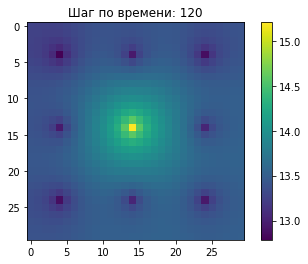

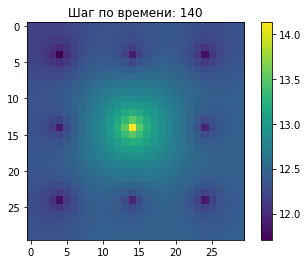

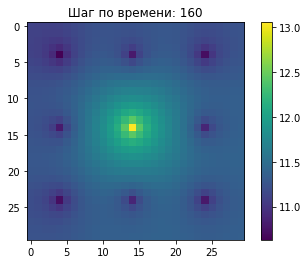

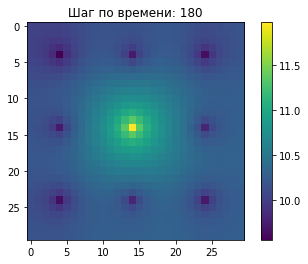

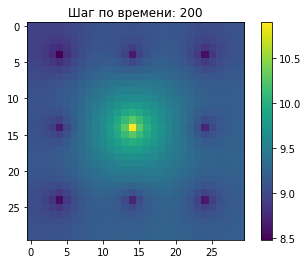

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # вывод трёх знаков после запятой
for i, field in enumerate(p):
    if i % 20 == 0:
        plt.figure()
        plt.title(f'Шаг по времени: {i}')
        plt.imshow(field / 1e6)
        plt.colorbar()
        plt.show()